# Extraction of electrical features (eFeatures) from experimental data

____

## Overview (from last week)

____

In this tutorial we will see how to extract electrical features (eFeatures), such as spike amplitude, firing frequency, etc... from experimental traces. The eFeatures describe the electrical behavior our neuron model should reproduce.

The steps we will follow are:

* Select and visualize the data.

* Electrophysiological features will be extracted from the voltage traces, thanks to the ** Electrophys Feature Extraction Library ** [eFEL](https://github.com/BlueBrain/eFEL).

* We will use experimental current traces to create protocols that we will use to simulate our neuron model.

* In future weeks we will use the **Blue Brain Python Optimisation Library** [BluePyOpt](https://github.com/BlueBrain/BluePyOpt) to create a model template for the [NEURON simulator](https://www.neuron.yale.edu/neuron/). There you'll see how the morphology you've chosen, the eFeatures and the stimuli will be combined in setting up the optimization of your neuron model.

___
### You will implement part of the code in order to perform the steps above (follow the **TODOs** in this notebook).
___

In [1]:
 # To avoid problems, install the pacakges you will need.
#! pip install --upgrade pip
#! pip install json2html
# First execute this line to upgrade pip
#! pip install -q --upgrade "hbp-service-client==1.0.0"

### RESTART YOUR KERNEL NOW!

Import some useful Python modules.

In [2]:
%load_ext autoreload
%autoreload

import numpy, IPython
import json, os

import matplotlib.pyplot as plt
%matplotlib inline

import collections

from json2html import *

# 1. Electrophysiology data

Go to the __MOODLE__ and download the folder called __Layer5TuftedPyramidal.tar__ files. Then, save these files in the __Storage__ of your collab. (Please, unzip the folder before saving it in the Storage). There are a lot of files, so is better to create a folder in the Storage and save the files in the folder. I called the folder __"dataLayer5TuftedPyramidal"__

In this section we will process the electrophysiological data recorded with patch clamp (current clamp) experiments.

We will store the data in a Python dictionary.

In [4]:
import os 
path = "data/week7/Layer5TuftedPyramidal/"
l = os.listdir(path)

In [5]:
# Download the files from the Storage to your collab virtual machine
# Save the file's names in a list
# Be patient it could take some minutes...

# These lines allow us to take and work with the desired files in the storage.
#clients = get_hbp_service_client()
#collab_path = get_collab_storage_path()
#data_dir = collab_path + '/dataLayer5TuftedPyramidal/'

#print files_list
#project_uuid = clients.storage.api_client.get_entity_by_query(path=data_dir)['uuid']
#l = clients.storage.api_client.list_folder_content(project_uuid, page_size=300)

filenames = []
for e in l:
    filenames.append(e)

for filename in filenames:
    print filename
    #path = path+filename
   #clients.storage.download_file(str(data_dir+filename), str(path_to_file))

exp_IV_ch21_2028.dat
exp_APWaveform_ch21_2032.dat
exp_IDRest_ch21_3106.dat
exp_APWaveform_ch20_1063.dat
exp_IDRest_ch21_1141.dat
exp_IV_ch20_3020.dat
exp_IDRest_ch21_1142.dat
exp_IV_ch20_2028.dat
exp_IDRest_ch21_2108.dat
exp_IDRest_ch21_2109.dat
exp_IV_ch21_2023.dat
exp_IV_ch20_4030.dat
exp_IV_ch20_2023.dat
exp_IV_ch20_2029.dat
exp_IV_ch21_3026.dat
exp_IV_ch20_2026.dat
exp_APWaveform_ch21_3032.dat
exp_IV_ch20_4028.dat
exp_IV_ch21_1058.dat
exp_IV_ch21_4027.dat
exp_IV_ch21_1050.dat
exp_IDRest_ch21_4108.dat
exp_IV_ch21_4025.dat
exp_IV_ch20_3019.dat
exp_APWaveform_ch21_3030.dat
exp_APWaveform_ch20_2032.dat
exp_IDRest_ch20_4113.dat
exp_IDRest_ch21_4105.dat
exp_IDRest_ch20_1135.dat
exp_APWaveform_ch21_4031.dat
exp_IDRest_ch21_3101.dat
exp_IV_ch21_4029.dat
exp_IDRest_ch21_4111.dat
exp_APWaveform_ch20_1064.dat
exp_APWaveform_ch21_4035.dat
exp_IV_ch21_1054.dat
exp_IV_ch21_4030.dat
exp_IDRest_ch21_4106.dat
exp_IV_ch21_2027.dat
exp_IV_ch20_1053.dat
exp_APWaveform_ch20_2035.dat
exp_IDRest_ch20_211

___
### Traces description

* All the recordings you see above represent different **stimuli** (e.g. "APWaveform", "IDRest", "IV"). 
* Each stimulus comprises different **sweeps** (e.g. "APWaveform*46-51"), of increasing/decreasing amplitudes.
* Each stimulus is repeated multiple times (e.g. APWaveform 46-51, 1042-1047, 2042-2047, 3042-3047 ). In this example above we have four **repetitions** of each stimulus.

Any individual recording has a trace number (e.g. "_1046"). Note that we have pairs of recordings with the same trace number (e.g. "exp_APWaveform_ch7_51.dat" and "exp_APWaveform_ch6_51.dat"). One of them contains the current stimulus (in this case "*ch7*") and the other the voltage response (in this case "*ch6*").
___

**TODO** With the code below we select traces based on trace number and store them in Python dictionaries. Last week we chose three stimuli and three repetitions. You are free to choose less stimuli, if you think that the firing of your neuron can be well described with a smaller stimuli subset. However, you should choose more than one repetition, as we've seen that the same cell may respond a bit differently although the stimulus is the same.

If you choose different stimuli, look carefully at the code below the "TODO", to have the appropriate number of entries and names in the "steps_v_dict" and "stepv_i_dict".

In [6]:
# TODO modify the line below to write the trace numbers of your choice in the list "selected traces"
selected_traces = [2106,2107, 2108, 2109, 2110, 2032, 2033,2034, 2035, 2036, 4027, 4026, 4025, 4024, 4023]

# Store voltage data in a dictionary step_name : [list of repetitions]
steps_v_dict = collections.OrderedDict({'LongStepNeg': [], 'ShortStepPos': [], 'LongStepPos': []})

# Store current data in a dictionary step_name : [list of repetitions]
steps_i_dict = collections.OrderedDict({'LongStepNeg': [], 'ShortStepPos': [], 'LongStepPos': []})

for file_name in filenames:
    # Get channel and trace number from the file_name
    channel = int(file_name[:-4].split('_')[2][2:])
    tracenum = int(file_name[:-4].split('_')[-1])
    path_to_file = path+file_name
    
    # Even channel numbers are voltage traces in this case
    if channel % 2 == 0:
        if "APWaveform" in file_name and tracenum in selected_traces:
            steps_v_dict['ShortStepPos'].append(numpy.fromfile(path_to_file))
        if "IDRest" in file_name and tracenum in selected_traces:
            steps_v_dict['LongStepPos'].append(numpy.fromfile(path_to_file))
        if "IV" in file_name and tracenum in selected_traces:
            steps_v_dict['LongStepNeg'].append(numpy.fromfile(path_to_file))
            
    # Odd channel numbers are voltage traces in this case        
    elif channel % 2 == 1:
        if "APWaveform" in file_name and tracenum in selected_traces:
            steps_i_dict['ShortStepPos'].append(numpy.fromfile(path_to_file))
        if "IDRest" in file_name and tracenum in selected_traces:
            steps_i_dict['LongStepPos'].append(numpy.fromfile(path_to_file))
        if "IV" in file_name and tracenum in selected_traces:
            steps_i_dict['LongStepNeg'].append(numpy.fromfile(path_to_file))
  


**TODO** We can now plot these traces.

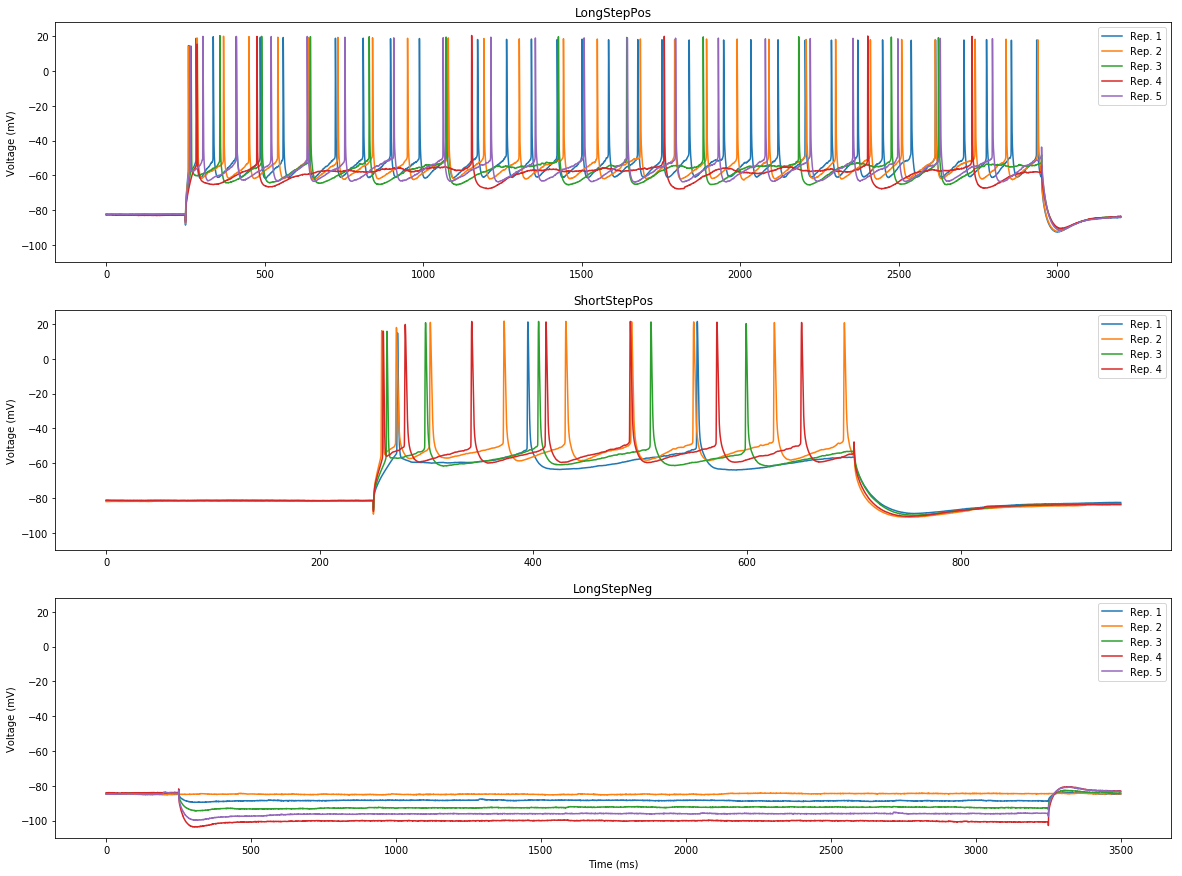

In [7]:
# TODO: if you run this cell, without any modification, you should see the traces. 
# Each subpart of the figure shows the repetitions of one stimulus

# Initialize a figure
fig1, axes = plt.subplots(len(steps_v_dict), sharey = True, figsize=(20,15))

# Plot the voltage traces
for idx, step_name in enumerate(steps_v_dict.keys()):
    for rep, trace in enumerate(steps_v_dict[step_name]):
        data = trace.reshape(len(trace)/2,2)
        axes[idx].plot(data[:,0],data[:,1], label = 'Rep. ' + str(rep+1))
        axes[idx].set_ylabel('Voltage (mV)')
        axes[idx].legend(loc = 'best')
        axes[idx].set_title(step_name)
    axes[-1].set_xlabel('Time (ms)')

# 2. Electrophysiological features
To build a detailed neuron model, we need to quantify the electrical behavior we want to reproduce. The metrics we use are the eFeatures, that measure parameters describing for instance the shape of the action potential or the firing rate of a neuron.

The eFeatures extracted from the data and later from the model will be used to compare the model's responses with the experimental data. The mean features values, along with the standard deviations will be stored in a .json file.

**TODO** You will define the information on the stimulus start and end times, along with the eFeatures you want to extract. Look at [here](http://bluebrain.github.io/eFEL/eFeatures.html) to have an idea on the eFeatures that you can extract or use the function "efel.getFeatureNames()"

In [8]:
# Extract features
import efel

# TODO: Look at the plots above to find the stimulus start and end time for each stimulus (in ms),
# Replace "0" and "10000' with stimulus start and end times
steps_info = {'LongStepNeg': [200, 3500], 'ShortStepPos': [200, 900], 'LongStepPos': [250, 3500]}

# TODO: write here the feature names of your choice, for each stimulus you've chosen
LongStepNeg_feat = ['voltage_base','voltage_deflection_begin'] 
                    #'AHP_depth_abs', 'AP_width','ISI_CV', 'time_constant', 'mean_frequency', 
                    #'AP_amplitude',  'time_to_first_spike', 'voltage_deflection', 'doublet_ISI'
LongStepPos_feat = ['voltage_base','voltage_deflection_begin', 'AP_amplitude', 'mean_frequency',
                    'ISI_CV', 'doublet_ISI','AHP_depth_abs', 'time_to_first_spike', 'AP_width',
                    'time_constant' ] #,'voltage_deflection']
ShortStepPos_feat = ['voltage_base', 'voltage_deflection','voltage_deflection_begin', 'AP_amplitude', 
                     'doublet_ISI', 'time_to_first_spike', 'AP_width']
                    #'time_constant' ,'ISI_CV', 'AHP_depth_abs','mean_frequency',]

# Prepare the traces for eFEL
def get_features(data):
    # All the traces converted in eFEL format
    efel_traces = {'LongStepNeg': [], 'ShortStepPos': [], 'LongStepPos': []}
    for step_name, step_traces in data.items():
        for rep in step_traces:            
            data = rep.reshape(len(rep)/2,2)
            # A single eFEL trace 
            trace = {}
            trace['T'] = data[:,0]
            trace['V'] = data[:,1] 
            trace['stim_start'] = [steps_info[step_name][0]]
            trace['stim_end'] = [steps_info[step_name][1]]
            trace['name'] = step_name
            
            efel_traces[step_name].append(trace)
    
    features_values = collections.defaultdict(dict)       
    
    features_values['LongStepNeg'] = efel.getMeanFeatureValues(efel_traces['LongStepNeg'], LongStepNeg_feat)
    
    features_values['LongStepPos'] = efel.getMeanFeatureValues(efel_traces['LongStepPos'], LongStepPos_feat)
    
    features_values['ShortStepPos'] = efel.getMeanFeatureValues(efel_traces['ShortStepPos'], ShortStepPos_feat)    

    return features_values

efel.getFeatureNames()

['AHP1_depth_from_peak',
 'AHP2_depth_from_peak',
 'AHP_depth',
 'AHP_depth_abs',
 'AHP_depth_abs_slow',
 'AHP_depth_diff',
 'AHP_depth_from_peak',
 'AHP_slow_time',
 'AHP_time_from_peak',
 'AP1_amp',
 'AP1_begin_voltage',
 'AP1_begin_width',
 'AP1_peak',
 'AP1_width',
 'AP2_AP1_begin_width_diff',
 'AP2_AP1_diff',
 'AP2_AP1_peak_diff',
 'AP2_amp',
 'AP2_begin_voltage',
 'AP2_begin_width',
 'AP2_peak',
 'AP2_width',
 'AP_amplitude',
 'AP_amplitude_change',
 'AP_amplitude_diff',
 'AP_amplitude_from_voltagebase',
 'AP_begin_indices',
 'AP_begin_time',
 'AP_begin_voltage',
 'AP_begin_width',
 'AP_duration',
 'AP_duration_change',
 'AP_duration_half_width',
 'AP_duration_half_width_change',
 'AP_end_indices',
 'AP_fall_indices',
 'AP_fall_rate',
 'AP_fall_rate_change',
 'AP_fall_time',
 'AP_height',
 'AP_phaseslope',
 'AP_phaseslope_AIS',
 'AP_rise_indices',
 'AP_rise_rate',
 'AP_rise_rate_change',
 'AP_rise_time',
 'AP_width',
 'APlast_amp',
 'APlast_width',
 'BAC_maximum_voltage',
 'BAC_w

**TODO** We can now visualise the feature values we computed, each row in the table corresponds to a repetition of the same step.

In [9]:
# TODO: run the code below to visualize the features extracted from each repetition, each stimulus. 
# Do these values make sense?

efel_features = dict(get_features(steps_v_dict))
IPython.display.HTML(json2html.convert(json=efel_features))

We can notice that the None results striclty depend on the traces. For example if there is not any AP, all the features related to that will not be meaningful.

We compute features mean and standard deviation.

In [10]:
#TODO: run the code below to compute the mean and standard deviations from the repetitions of each stimulus

features_dict = collections.OrderedDict()
for step_name, reps in efel_features.items():
    feature_values = collections.defaultdict(list)
    for rep in reps: 
        for feature_name, value in rep.iteritems():
            feature_values[feature_name].append(value)
   
    features_dict[step_name] = {"soma":{}}
    for name, values in feature_values.items():
        features_dict[step_name]["soma"][name] = [numpy.mean(values), numpy.std(values)]
        
IPython.display.HTML(json2html.convert(json=dict(features_dict)))

We write the eFeatures in a .json file that we will use later in the exercise.

In [11]:
# TODO: run the code below to save the efeatures in a .json file. You can also open it with a text editor and compare
# with the same file we obtained last week.
with open('features.json', 'w') as fp:
    json.dump(features_dict, fp, indent = 4)

In [12]:
# Let's see if we had created the file in the working directory of the collab virtual machine.
! ls

data				   features.json
efelTutorial_2_week7_Ilaria.ipynb  week5_neuroM_tutorial_Olesya.ipynb
efel_Tutorial_Ilaria.ipynb	   week6_efel_tutorial.ipynb


In [13]:
# Execute the lines below
# This will save the files in the storage
#clients = get_hbp_service_client()
#collab_path = get_collab_storage_path()
#clients.storage.upload_file('features.json', data_dir + '/features.json', 'application/JSON')

__TODO__ Compute all the possible eFeatures for the different traces during the different protocols.
Why is it possible to comute some of them and not others?

Hint: You can create a table or a bitmap to explain the solution in your project.


## 3. Write out the stimulation protocols

Now it's time to process the current stimuli that were used to record the voltage responses seen above.

We will estimate the stimuli amplitude from the trace and save them in a file "protocols.json". They will be used later on in the project to stimulate your neuron model.

**TODO** Plot the current traces

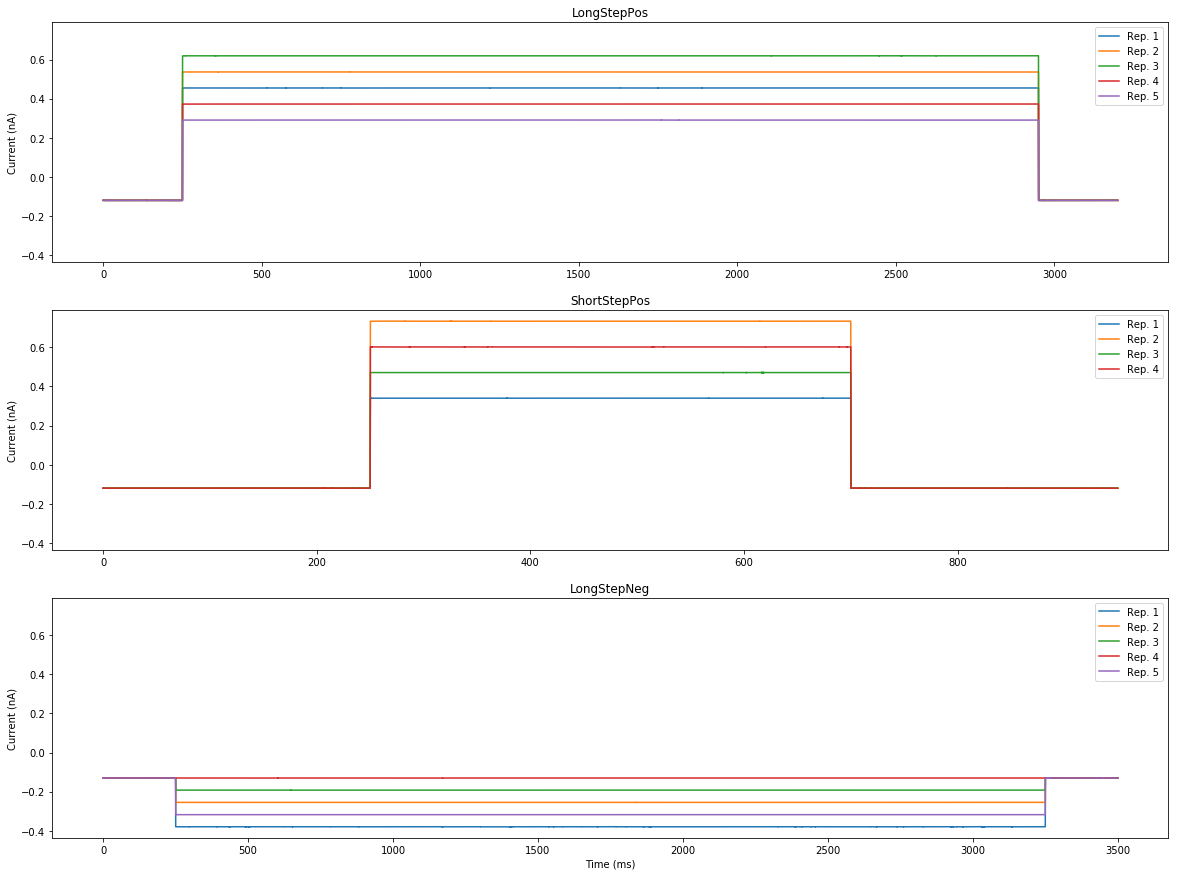

In [14]:
# TODO: run this cell to visualize the current stimuli. The graph should appear similar 
# to the one with the voltage responses (multiple repetitions grouped by stimulus name)

# Plot the current traces
# Initialize a figure
fig1, axes = plt.subplots(len(steps_i_dict), sharey = True, figsize=(20,15))

for idx, step_name in enumerate(steps_i_dict.keys()):
    for rep, trace in enumerate(steps_i_dict[step_name]):
        data = trace.reshape(len(trace)/2,2)
        axes[idx].plot(data[:,0],data[:,1], label = 'Rep. ' + str(rep+1))
        axes[idx].set_ylabel('Current (nA)')
        axes[idx].legend(loc = 'best')
        axes[idx].set_title(step_name)
    axes[-1].set_xlabel('Time (ms)')

**TODO** copy the "steps_info" dictionary.

In [15]:
protocols_dict = collections.OrderedDict()

# TODO: Replace the line below to copy the "steps_info" dictionary. 
# We will use the stimuli start and end to write the current protocol to simulate the response in our neuron
steps_info = {'LongStepNeg': [200, 3500], 'ShortStepPos': [200, 900], 'LongStepPos': [250, 3500]}

# Stimuli holding current and step current amplitudes in nA
amps_info = collections.defaultdict(list)
for step_name in steps_i_dict.keys():
    
    iholds = []
    isteps = []
    for trace in steps_i_dict[step_name]:
        data = trace.reshape(len(trace)/2,2)
        tot_duration = steps_info[step_name][1]+steps_info[step_name][0]
   
        dt = float(tot_duration)/len(data)
        ihold = numpy.mean(data[:,1][0:int(steps_info[step_name][0]/dt)])

        istep = numpy.mean(data[:,1][int(steps_info[step_name][0]/dt):int(steps_info[step_name][1]/dt)])-ihold
        iholds.append(ihold)
        isteps.append(istep)
       
    amps_info[step_name].append(round(numpy.mean(isteps), 4))
    amps_info[step_name].append(round(numpy.mean(iholds), 4)) 
    
#amps_info  = {'LongStepNeg': [-0.01, 0.05], 'ShortStepPos': [0.18,0.05],'LongStepPos': [0.15 ,0.05]}

for step_name, reps in efel_features.items():   
    protocols_dict[step_name] = {"stimuli":[]}
    protocols_dict[step_name]["stimuli"].append({"delay":steps_info[step_name][0],
                                               "amp":amps_info[step_name][0],
                                               "duration":steps_info[step_name][1]-steps_info[step_name][0],
                                               "totduration":steps_info[step_name][1]+steps_info[step_name][0]})
    protocols_dict[step_name]["stimuli"].append({"delay":0,
                                               "amp":amps_info[step_name][1],
                                               "duration":steps_info[step_name][1]+steps_info[step_name][0],
                                               "totduration":steps_info[step_name][1]+steps_info[step_name][0]})
 

In [16]:
# TODO: run the line below to visualize the protocols that we have computed. 
# For each stimulus you should have two lines, representing the step current parameters and the holding current parameters
IPython.display.HTML(json2html.convert(json=dict(protocols_dict)))

In [17]:
# TODO: save the protocols in the "protocols.json" information
# Save the protocols in a .json file
with open('protocols.json', 'w') as fp:
    json.dump(protocols_dict, fp, indent = 4)

In [ ]:
# Execute the lines below
# This will save the file in the storage
#clients = get_hbp_service_client()
#collab_path = get_collab_storage_path()
#clients.storage.upload_file('protocols.json', data_dir + '/protocols.json', 'application/JSON')